# **Exploring order book predictability in cryptocurrency markets in a deep learning perspective using JAX**

This notebook is used to explore order book predictability in cryptocurrency markets. We choose Bitcoin because it is the most widely known and thus the most liquid. We shine some lights on clear signs of short/mid term predictability.

### **Data**
We use the BTCUSDT book ticker, available publicly for the first day of each month on [Tardis.dev](https://docs.tardis.dev/historical-data-details/binance). It can be downloaded with the tardis-dev python library.

### **References**
[1] Zhang Z, Zohren S, Roberts S. DeepLOB: Deep convolutional neural networks for limit order books. IEEE Transactions on Signal Processing. 2019 Mar 25. https://arxiv.org/abs/1808.03668

[2] Kolm, Petter N. and Turiel, Jeremy and Westray, Nicholas, Deep Order Flow Imbalance: Extracting Alpha at Multiple Horizons from the Limit Order Book. 2021 August 5. [https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3900141](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3900141)

[3] Lucchese L, S.Pankkanen M, E.D.Veraart A. THE SHORT-TERM PREDICTABILITY OF RETURNS IN ORDER BOOK MARKETS: A DEEP LEARNING PERSPECTIVE. 2023 Oct 10. [https://arxiv.org/pdf/2211.13777.pdf](https://arxiv.org/pdf/2211.13777.pdf)

[4] Dean Markwick. Order Flow Imbalance - A High Frequency Trading Signal. 2022 Feb 2. [https://dm13450.github.io/2022/02/02/Order-Flow-Imbalance.html](https://dm13450.github.io/2022/02/02/Order-Flow-Imbalance.html)


In [ ]:
!pip install pandas tardis-dev tqdm pyarrow clu --quiet

In [ ]:
from tardis_dev import datasets
from datetime import datetime
from dateutil.relativedelta import relativedelta
import nest_asyncio
nest_asyncio.apply()

today = datetime.now()
if today.day <= 2:
  today = today - relativedelta(months=1)

days = [datetime(today.year, today.month, 1) - i*relativedelta(months=1) for i in range(6)][::-1]

for day in days:
  datasets.download(
      exchange="binance",
      data_types=["book_ticker"],
      from_date=day.strftime("%Y-%m-%d"),
      to_date=(day+relativedelta(days=1)).strftime("%Y-%m-%d"),
      symbols=["BTCUSDT"])

file_paths = [f'datasets/binance_book_ticker_{day.strftime("%Y-%m-%d")}_BTCUSDT.csv.gz' for day in days]
file_paths

['datasets/binance_book_ticker_2023-08-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2023-09-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2023-10-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2023-11-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2023-12-01_BTCUSDT.csv.gz',
 'datasets/binance_book_ticker_2024-01-01_BTCUSDT.csv.gz']

In [ ]:
import pandas as pd
pd.set_option('display.max_columns', 100)

df = pd.concat([pd.read_csv(file_path, engine='pyarrow') for file_path in file_paths], axis=0)
df.drop(['local_timestamp'], axis=1, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='us')
df.set_index('timestamp', inplace=True)
df

,exchange,symbol,ask_amount,ask_price,bid_price,bid_amount
timestamp,,,,,,
2023-08-01 00:00:00.003862,binance,BTCUSDT,12.83141,29232.26,29232.25,7.65386
2023-08-01 00:00:00.003865,binance,BTCUSDT,12.82987,29232.26,29232.25,7.65386
2023-08-01 00:00:00.003866,binance,BTCUSDT,12.82372,29232.26,29232.25,7.65386
2023-08-01 00:00:00.003901,binance,BTCUSDT,12.82372,29232.26,29232.25,7.64467
2023-08-01 00:00:00.004719,binance,BTCUSDT,12.82372,29232.26,29232.25,7.64320
...,...,...,...,...,...,...
2024-01-01 23:59:59.989734,binance,BTCUSDT,2.95632,44179.55,44179.54,5.41314
2024-01-01 23:59:59.993172,binance,BTCUSDT,2.95386,44179.55,44179.54,5.41314
2024-01-01 23:59:59.993225,binance,BTCUSDT,2.95386,44179.55,44179.54,5.41105


## **Processing the training data**

We are totalizing 22M rows containing the first level of the order book.
The data will be processed and labelled as:
  - Sell (label 0)
  - Hold (label 1)
  - Buy (label 2)

The label of a row is computed as follows:
For a row at time $t$, we denote $b_t$ and $a_t$ the bid and ask price, define the sell and buy return at time $t$ and horizon $h$ as:
$$r_t^{\text{sell}} = \dfrac{b_t - \dfrac{1}{h}\sum_{s=1}^h a_{t+s}}{b_t};
r_t^{\text{buy}} = \dfrac{\dfrac{1}{h}\sum_{s=1}^h b_{t+s} - a_t}{a_t}$$

The parameter $h$ is purely ad-hoc, it represents the size of the lookahead window. We will try to keep the number of these ad-hoc parameters as low as possible, to ensure more fitting to the training data result in more accuracy in a real market context.

**Explanation**: if we sell at time $t$, $\dfrac{1}{h}\sum_{s=1}^h a_{t+s}$ is the smoothed ask price over h steps in the future, we want this value to be low (e.g the price descending) to buy later at a better price. $r_t^{\text{sell}}$ is then computed by weighting this smoothed ask return with the price we sold at ($b_t$).
The smoothing is necessary due to a lot of noise and volatilty in the cryptocurrency markets, we need to ensure the prices have made a noticeable change to label a row as buy, or sell.

This definition of $r$ differs from the current litterature, in [3] Lucchese and al; used only the mid price to compute the return at time t.
In our trading perspective, we must take into account only tradable price (e.g. the bid and ask prices)

Moreover the spread, the difference between the ask and bid price, can spike to large values in periods of high volatility, making $m_t$ a worse approximation of the real market state.

More definitions of returns are explored in [3]

Then we introduce $\gamma$ which is the threshold above which a row will be labelled at 0, or 2.

A row is labelled as 0 (sell) if $r_t^{\text{sell}} > \gamma$, labelled as 2 (buy) if $r_t^{\text{buy}} > \gamma$, otherwise the row is labelled as 1 (hold).

**Setting 0 as gamma will label a row as buy if and only if the smoothed bid price over h steps ahead beats the spread (e.g. we are making profits).**

The labeled rows undergo further processing, involving the normalization of bid and ask amounts. Additionally, bid and ask prices are replaced with a weighted spread. These three features—normalized bid amount, normalized ask amount, and weighted spread—constitute the training data.

In [ ]:
def process_data(temp_df, h, gamma, T):
  print('from', temp_df.index[0], 'to', temp_df.index[-1])
  temp_df.reset_index(drop=True, inplace=True)

  temp_buy_index = pd.Series(temp_df[((temp_df['bid_price'].iloc[::-1].rolling(window=h).sum()/h).shift(1).iloc[::-1] - temp_df['ask_price']) / temp_df['ask_price'] > gamma].index)
  temp_sell_index = pd.Series(temp_df[(temp_df['bid_price'] - (temp_df['ask_price'].iloc[::-1].rolling(window=h).sum()/h).shift(1)) / temp_df['bid_price'] > gamma].index)

  temp_df.loc[:, 'spread'] = 2 * (temp_df['ask_price'] - temp_df['bid_price']) / (temp_df['ask_price'] + temp_df['bid_price'])
  temp_df[['bid_amount', 'ask_amount']] = temp_df[['bid_amount', 'ask_amount']].div(temp_df[['bid_amount', 'ask_amount']].sum(axis=1), axis=0)

  temp_buy_points = temp_buy_index[temp_buy_index.diff(-1) != -1]
  temp_sell_points = temp_sell_index[temp_sell_index.diff(-1) != -1]

  temp_buy_windows = np.stack([temp_buy_points - t for t in range(T)]).T[:, ::-1]
  temp_sell_windows = np.stack([temp_sell_points - t for t in range(T)]).T[:, ::-1]

  temp_buys = temp_df.values[:, 2:][temp_buy_windows]
  temp_sells = temp_df.values[:, 2:][temp_sell_windows]

  temp_N = min(len(temp_buys), len(temp_sells))

  temp_hold_index = np.random.choice(temp_df.index.difference(temp_buy_index).difference(temp_sell_index), size=temp_N)
  temp_hold_windows = np.stack([temp_hold_index - t for t in range(T)]).T[:, ::-1]
  temp_holds = temp_df.values[:, 2:][temp_hold_windows]

  temp_buys = temp_buys[np.random.choice(temp_buys.shape[0], temp_N, replace=False)]
  temp_sells = temp_sells[np.random.choice(temp_sells.shape[0], temp_N, replace=False)]

  print(temp_buys.shape[0], 'buys')
  print(temp_holds.shape[0], 'holds')
  print(temp_sells.shape[0], 'sells', end='\n\n')

  temp_books = np.vstack((temp_buys, temp_holds, temp_sells))
  temp_labels = np.array([2]*temp_buys.shape[0]+[1]*temp_holds.shape[0]+[0]*temp_sells.shape[0])

  temp_ds = {'book': jnp.array(temp_books),
              'label': jnp.array(temp_labels)}
  return temp_ds

## **The Neural Network**

Inline with the current litterature, we use a CNN to efficiently capture the patterns in the order book features, leading to market changes.

We use Flax and Jax to write a general CNN whose hyperparameters can be changed and tuned efficiently.

In [ ]:
from flax import linen as nn
from flax.training import train_state
import jax
import jax.numpy as jnp
import numpy as np
import optax
from tqdm import tqdm, trange
from clu import parameter_overview
from typing import Any
import pandas as pd
from datetime import datetime

class TrainState(train_state.TrainState):
  batch_stats: Any

class CNN(nn.Module):
    """CNN Model"""
    kernel_size_1: int
    kernel_size_2: int
    kernel_size_3: int
    padding: str
    features: int
    dense: int
    activation: str

    @nn.compact
    def __call__(self, x, train):
        x = nn.Conv(features=2**self.features,
                    kernel_size=(1, self.kernel_size_1))(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")
        x = nn.Conv(features=2**self.features,
                    kernel_size=(self.kernel_size_2, 1),
                    padding=self.padding)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")
        x = nn.Conv(features=2**self.features,
                    kernel_size=(self.kernel_size_3, 1),
                    padding=self.padding)(x)
        x = nn.BatchNorm(use_running_average=not train)(x)
        x = eval(f"nn.{self.activation}(x)")

        x = x.reshape((x.shape[0], -1))

        x = nn.Dense(features=2**self.dense)(x)
        x = eval(f"nn.{self.activation}(x)")

        x = nn.Dense(features=3)(x) # buy, hold or sell
        return x

@jax.jit
def apply_model(state, books, labels):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn(params):
    logits, updates = state.apply_fn({'params': params, 'batch_stats': state.batch_stats},
                                     books,
                                     train=True,
                                     mutable=['batch_stats'])
    one_hot = jax.nn.one_hot(labels, 3)
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, (logits, updates)

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, (logits, updates)), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, updates, loss, accuracy

@jax.jit
def update_model(state, grads, updates):
  state = state.apply_gradients(grads=grads)
  state = state.replace(batch_stats=updates['batch_stats'])
  return state

def train_epoch(state, train_ds, batch_size, rng):
  """Train for a single epoch."""
  train_ds_size = len(train_ds['book'])
  steps_per_epoch = train_ds_size // batch_size

  perms = jax.random.permutation(rng, len(train_ds['book']))
  perms = perms[: steps_per_epoch * batch_size]  # skip incomplete batch
  perms = perms.reshape((steps_per_epoch, batch_size))

  epoch_loss = []
  epoch_accuracy = []

  for perm in tqdm(perms):
    batch_books = train_ds['book'][perm, ...]
    batch_labels = train_ds['label'][perm, ...]
    grads, updates, loss, accuracy = apply_model(state, batch_books, batch_labels)
    state = update_model(state, grads, updates)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy


def create_train_state(rng, optimizer, learning_rate, T, hparams) -> TrainState:
  """Creates initial `TrainState`."""
  cnn = CNN(**hparams)
  variables = cnn.init(rng, jnp.ones([1, T, 3]), train=False)
  print(parameter_overview.get_parameter_overview(variables))
  params = variables['params']
  batch_stats = variables['batch_stats']
  tx = eval(f"optax.{optimizer}({learning_rate})")
  return TrainState.create(apply_fn=cnn.apply, params=params, tx=tx, batch_stats=batch_stats)


def train_and_evaluate(h, gamma, T, optimizer, learning_rate, batch_size, num_epochs, hparams) -> TrainState:
  """Execute model training and evaluation loop.

  Returns:
    The train state (which includes the `.params`).
  """

  print("Training data:")
  train_df = pd.concat([pd.read_csv(train_file_path, usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow') for train_file_path in file_paths[:-1]], axis=0)
  train_df['timestamp'] = pd.to_datetime(train_df['timestamp'], unit='us')
  train_df.set_index('timestamp', inplace=True)
  train_ds = process_data(train_df, h=h, gamma=gamma, T=T)

  print("Test data:")
  test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
  test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
  test_df.set_index('timestamp', inplace=True)
  test_ds = process_data(test_df, h=h, gamma=gamma, T=T)

  assert 'cuda' in str(train_ds['book'].devices())

  print("Training on shape", train_ds["book"].shape, train_ds['label'].shape)
  print("Testing on shape", test_ds["book"].shape, test_ds['label'].shape)

  rng = jax.random.key(0)
  rng, init_rng = jax.random.split(rng)

  state = create_train_state(init_rng, optimizer, learning_rate, T, hparams)
  for epoch in range(1, num_epochs + 1):
    rng, input_rng = jax.random.split(rng)
    state, train_loss, train_accuracy = train_epoch(state, train_ds, batch_size, input_rng)
    _, _, test_loss, test_accuracy = apply_model(state, test_ds['book'], test_ds['label'])
    print('epoch:% 3d, train_loss: %.4f, train_accuracy: %.2f, test_loss: %.4f,'
          ' test_accuracy: %.2f,' % (epoch,
                                    train_loss,
                                    train_accuracy * 100,
                                    test_loss,
                                    test_accuracy * 100))
  return state

## **Hyperparameters**

Hyperparameters have been found conducting a extensive hyperparameters tuning study with [Optuna](https://optuna.readthedocs.io/en/stable/index.html)

Find more information about hyperparameter tuning in Jax in [Guide 4: Research Projects with JAX](https://uvadlc-notebooks.readthedocs.io/en/latest/tutorial_notebooks/guide4/Research_Projects_with_JAX.html)

In [ ]:
h = 50
gamma = 0
T = 10

num_epochs = 10
learning_rate = 0.03
batch_size = 1024

hparams = {'kernel_size_1': 1,
         'kernel_size_2': 5,
         'kernel_size_3': 8,
         'padding': 'SAME',
         'features': 6,
         'dense': 9,
         'activation': 'hard_swish'}

optimizer = "novograd"

state = train_and_evaluate(h, gamma, T, optimizer, learning_rate, batch_size, num_epochs, hparams)

Training data:
from 2023-08-01 00:00:00.003862 to 2023-12-01 23:59:59.998659
65056 buys
65056 holds
65056 sells

Test data:
from 2024-01-01 00:00:00.002131 to 2024-01-01 23:59:59.996517
10881 buys
10881 holds
10881 sells

Training on shape (195168, 10, 3) (195168,)
Testing on shape (32643, 10, 3) (32643,)
+------------------------------+----------------+---------+-----------+--------+
| Name                         | Shape          | Size    | Mean      | Std    |
+------------------------------+----------------+---------+-----------+--------+
| batch_stats/BatchNorm_0/mean | (64,)          | 64      | 0.0       | 0.0    |
| batch_stats/BatchNorm_0/var  | (64,)          | 64      | 1.0       | 0.0    |
| batch_stats/BatchNorm_1/mean | (64,)          | 64      | 0.0       | 0.0    |
| batch_stats/BatchNorm_1/var  | (64,)          | 64      | 1.0       | 0.0    |
| batch_stats/BatchNorm_2/mean | (64,)          | 64      | 0.0       | 0.0    |
| batch_stats/BatchNorm_2/var  | (64,)       

100%|██████████| 190/190 [00:06<00:00, 31.27it/s] 


epoch:  1, train_loss: 0.5259, train_accuracy: 79.13, test_loss: 0.5074, test_accuracy: 82.58,


100%|██████████| 190/190 [00:01<00:00, 147.55it/s]


epoch:  2, train_loss: 0.4637, train_accuracy: 82.31, test_loss: 0.4303, test_accuracy: 84.62,


100%|██████████| 190/190 [00:01<00:00, 154.15it/s]


epoch:  3, train_loss: 0.4497, train_accuracy: 82.91, test_loss: 0.4860, test_accuracy: 81.95,


100%|██████████| 190/190 [00:01<00:00, 157.93it/s]


epoch:  4, train_loss: 0.4417, train_accuracy: 83.27, test_loss: 0.4597, test_accuracy: 82.70,


100%|██████████| 190/190 [00:01<00:00, 156.78it/s]


epoch:  5, train_loss: 0.4338, train_accuracy: 83.42, test_loss: 0.4320, test_accuracy: 83.73,


100%|██████████| 190/190 [00:01<00:00, 148.91it/s]


epoch:  6, train_loss: 0.4278, train_accuracy: 83.64, test_loss: 0.4376, test_accuracy: 83.24,


100%|██████████| 190/190 [00:01<00:00, 122.76it/s]


epoch:  7, train_loss: 0.4223, train_accuracy: 83.76, test_loss: 0.4099, test_accuracy: 84.13,


100%|██████████| 190/190 [00:01<00:00, 145.12it/s]


epoch:  8, train_loss: 0.4199, train_accuracy: 83.82, test_loss: 0.4046, test_accuracy: 84.55,


100%|██████████| 190/190 [00:01<00:00, 153.02it/s]


epoch:  9, train_loss: 0.4170, train_accuracy: 83.91, test_loss: 0.4580, test_accuracy: 82.46,


100%|██████████| 190/190 [00:01<00:00, 153.93it/s]


epoch: 10, train_loss: 0.4153, train_accuracy: 83.96, test_loss: 0.4389, test_accuracy: 83.56,


## **Evaluation**

Once we have an accurate model, we can evauate the model on the unseen test dataset, and calculate the predictions for each row.

In [ ]:
def evaluate(state, T, test_df, test_batch_size):
    preds = pd.DataFrame(index=test_df.index, columns=['sell', 'hold' ,'buy'])
    sliding_view = jnp.array(np.lib.stride_tricks.sliding_window_view(test_df.values, (T, 5)).reshape(-1, T, 5))
    for k in trange(0, sliding_view.shape[0], test_batch_size):
        test_batch = sliding_view[k: k+test_batch_size, :, 2:]
        logits, _ = state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, test_batch, train=False, rngs={'dropout': jax.random.key(1)}, mutable=['batch_stats'])
        class_probabilities = jax.nn.softmax(logits)
        preds.iloc[k+T-1: k+T-1+class_probabilities.shape[0]] = class_probabilities
    return preds

In [ ]:
test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
test_df.set_index('timestamp', inplace=True)
test_df.loc[:, 'spread'] = 2 * (test_df['ask_price'] - test_df['bid_price']) / (test_df['ask_price'] + test_df['bid_price'])
test_df[['bid_amount', 'ask_amount']] = test_df[['bid_amount', 'ask_amount']].div(test_df[['bid_amount', 'ask_amount']].sum(axis=1), axis=0)
test_batch_size = 2048*8


A prediction in a triplet [sell_confidence, hold_confidence, buy_confidence] of [0, 1], we log the predictions in a separate dataframe:

The first T-1 rows have no prediction since we need the last T rows to feed to the model

In [ ]:
preds = evaluate(state, T, test_df, test_batch_size)
preds

100%|██████████| 206/206 [00:09<00:00, 20.98it/s]


,sell,hold,buy
timestamp,,,
2024-01-01 00:00:00.002131,NaN,NaN,NaN
2024-01-01 00:00:00.009508,NaN,NaN,NaN
2024-01-01 00:00:00.009509,NaN,NaN,NaN
2024-01-01 00:00:00.009514,NaN,NaN,NaN
2024-01-01 00:00:00.009514,NaN,NaN,NaN
...,...,...,...
2024-01-01 23:59:59.989734,0.037119,0.911703,0.051177
2024-01-01 23:59:59.993172,0.038892,0.900678,0.06043
2024-01-01 23:59:59.993225,0.028013,0.932866,0.039121


Now we will implement a trading strategy based on the predictions.

We write a general function to get the associated price and amount for a buy/sell prediction.
In the perspective of a real market application, we take into account the latency between the moment we receive the book update, and the moment our order is actually filled in the exchange.

Binance offer a snippet to directly compute the latency between you and the market: [https://github.com/binance/binance-toolbox-python/blob/master/check_order_update_latency.py](https://github.com/binance/binance-toolbox-python/blob/master/check_order_update_latency.py)

Binance websocket servers are located in Tokyo, we use an AWS virtual machine located in this area to get the lowest latency and the results we got are around 4 ms to receive the order book update, then the model runs inference in about 37 ms, and our order is submitted and filled in 3ms according to our tests.

This brings the total latency to around 45 milliseconds, which is shockingly pedestrian in the high frequency trading realm. We are putting ourself at risk of buying or selling at a higher or lower price than the one we saw quoted. The gold standard in HFT is around 200 nonosecond.

Additionnaly, we assume that our activity doesn't impact the market, which is arguable if we start to trade large quantities

In [ ]:
%timeit state.apply_fn({'params': state.params, 'batch_stats': state.batch_stats}, jnp.ones([1, T, 3]), train=False, mutable=['batch_stats'])

38.9 ms ± 777 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [ ]:
def compute_prices(test_df, preds, latency=pd.Timedelta(milliseconds=50), confidences=np.linspace(1/3, 1, 10)):
    pred_df = pd.concat([test_df, preds], axis=1)
    conf_df = test_df.copy()
    for confidence in confidences:
        labels = pd.Series([1]*len(test_df.index), index=test_df.index, name=f'label_{round(confidence, 2)}', dtype=np.uint) # hold everything
        labels[preds.max(axis=1) > confidence] = np.argmax(preds.values, axis=1)[preds.max(axis=1) > confidence]
        conf_df = pd.concat([conf_df, labels], axis=1)

    df_temp = conf_df.copy()
    df_temp.index = df_temp.index - latency

    # Perform an asof merge to get the last price and amount at time timestamp + latency for each timestamp, direction backward to trade at the current market state after latency
    df_merged = pd.merge_asof(conf_df, df_temp[['bid_price', 'ask_price', 'bid_amount', 'ask_amount']], left_index=True, right_index=True, suffixes=('', '_future'), direction="backward")

    df_merged.drop(['ask_price', 'ask_amount', 'bid_price', 'bid_amount'], inplace=True, axis=1)
    return df_merged

In [ ]:
test_df = pd.read_csv(file_paths[-1], usecols=['timestamp', 'ask_price', 'bid_price', 'ask_amount', 'bid_amount'], engine='pyarrow')
test_df['timestamp'] = pd.to_datetime(test_df['timestamp'], unit='us')
test_df.set_index('timestamp', inplace=True)

In [ ]:
prices = compute_prices(test_df, preds)
prices

,label_0.33,label_0.41,label_0.48,label_0.56,label_0.63,label_0.7,label_0.78,label_0.85,label_0.93,label_1.0,bid_price_future,ask_price_future,bid_amount_future,ask_amount_future
timestamp,,,,,,,,,,,,,,
2024-01-01 00:00:00.002131,1,1,1,1,1,1,1,1,1,1,42283.58,42283.59,9.09309,2.82602
2024-01-01 00:00:00.009508,1,1,1,1,1,1,1,1,1,1,42283.58,42283.59,9.09309,2.82602
2024-01-01 00:00:00.009509,1,1,1,1,1,1,1,1,1,1,42283.58,42283.59,9.09309,2.82602
2024-01-01 00:00:00.009514,1,1,1,1,1,1,1,1,1,1,42283.58,42283.59,9.09309,2.82602
2024-01-01 00:00:00.009514,1,1,1,1,1,1,1,1,1,1,42283.58,42283.59,9.09309,2.82602
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-01 23:59:59.989734,1,1,1,1,1,1,1,1,1,1,44179.54,44179.55,5.40911,2.95308
2024-01-01 23:59:59.993172,1,1,1,1,1,1,1,1,1,1,44179.54,44179.55,5.40911,2.95308
2024-01-01 23:59:59.993225,1,1,1,1,1,1,1,1,1,1,44179.54,44179.55,5.40911,2.95308


In [ ]:
def compute_trades(prices):
  trades = {}
  for label_column in prices.filter(regex=r'label_').columns:
    confidence = float(label_column.split('_')[-1])
    conf_df = prices[[label_column, 'bid_price_future', 'ask_price_future', 'bid_amount_future', 'ask_amount_future']].copy()

    conf_df = conf_df[conf_df[label_column] != 1].dropna() # remove holds

    # Remove consecutive duplicate labels
    conf_df['group'] = (conf_df[label_column] != conf_df[label_column].shift()).cumsum()
    conf_df = conf_df.drop_duplicates(subset='group')
    conf_df.drop(columns='group', inplace=True)

    conf_df.loc[conf_df[label_column] == 2, 'price_future'] = - conf_df.loc[conf_df[label_column] == 2, 'ask_price_future']
    conf_df.loc[conf_df[label_column] == 0, 'price_future'] = conf_df.loc[conf_df[label_column] == 0, 'bid_price_future']
    conf_df.loc[conf_df[label_column] == 2, 'amount_future'] = conf_df.loc[conf_df[label_column] == 2, 'ask_amount_future']
    conf_df.loc[conf_df[label_column] == 0, 'amount_future'] = conf_df.loc[conf_df[label_column] == 0, 'bid_amount_future']

    conf_df.drop(['bid_price_future', 'ask_price_future', 'bid_amount_future', 'ask_amount_future'], inplace=True, axis=1)
    trades[confidence] = conf_df.copy()

  return trades

In [ ]:
trades = compute_trades(prices)
next(iter(trades.values()))

,label_0.33,price_future,amount_future
timestamp,,,
2024-01-01 00:00:00.967375,2,-42283.59,1.02111
2024-01-01 00:00:05.308726,0,42282.82,0.00062
2024-01-01 00:00:07.181095,2,-42269.58,7.40386
2024-01-01 00:00:07.182300,0,42269.57,0.00012
2024-01-01 00:00:07.182501,2,-42269.58,7.40386
...,...,...,...
2024-01-01 23:59:38.566579,2,-44174.01,0.35129
2024-01-01 23:59:47.222113,0,44179.46,3.13000
2024-01-01 23:59:47.226591,2,-44179.47,0.15922


For every confidence, we have the label along with price and the available quantity after latency for every signal

## **The trading strategy**

Define a trading strategy as a previsible process, given by the amounts (BTC_wallet, USDT_wallet)_n for each timestamp n.

The updated market price is given by (price, 1)_n

A trading strategy is said to be self-funded if for every n:

```
BTC_wallet_n * price_n + USDT_wallet_n = BTC_wallet_(n+1) * price_n + USDT_wallet_(n+1)
```
This means that the modification of the wallet composition at time n+1 is just a rearrangment of the wallet composition at time n. There is no additional funds, and no withdrawal.
This means that the more money we will earn during the process, the more money we will trade, leading to exponential value of our wallet.
Remember that an exponential can decrease (very fast...)

The strategy we adopt is self-funded and verify that our wallet value is always non negative. Such a strategy is called eligible. This means that we won't get into dept using it, but we can lose all our money.

An eligible strategy leading starting with an empty wallet and leading to positive profit is an arbitrage. This is making profit without taking any risk

As in [4], we compute the Sharpe ratio (SR) of our strategy, this metric is the expectancy of returns divided by the standard deviation of the returns, it measures how risky our strategy is compared to the yielded profits.

One would demand the Sharpe ratio to be at least over 1, meaning the expectancy of results is greater than variance of returns.

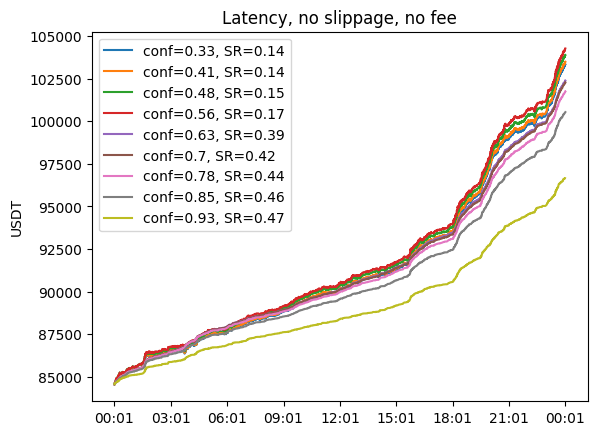

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

for confidence, trade in trades.items():
  if len(trade) <= 4: continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    amount = 1 # ignoring slippage
    if label == 0:
      trade_amount = min(BTC_wallet, amount)
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount)
      BTC_wallet += trade_amount/price
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, no slippage, no fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()

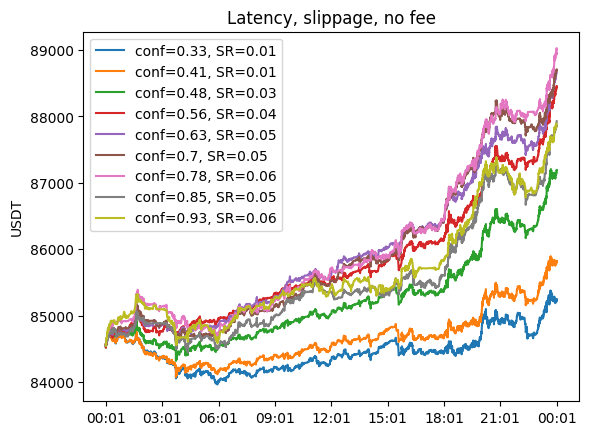

In [ ]:
for confidence, trade in trades.items():
  if not len(trade): continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    if label == 0:
      trade_amount = min(BTC_wallet, amount) # slippage
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount) # slippage
      BTC_wallet += trade_amount/price
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, slippage, no fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()

Still winnning

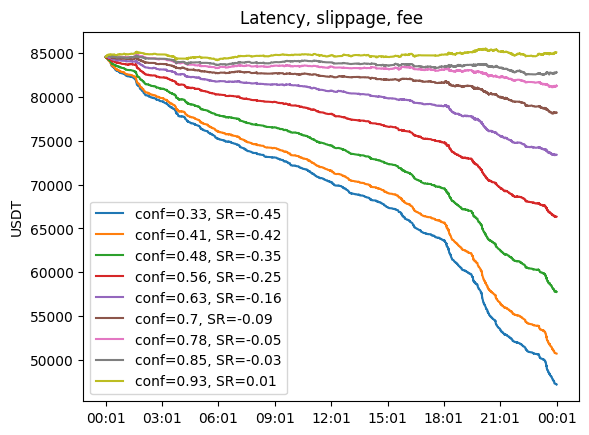

In [ ]:
maker_fee = 0.0090/100 # https://www.binance.com/en/fee/trading
taker_fee = 2*maker_fee
for confidence, trade in trades.items():
  if not len(trade): continue
  BTC_wallet = 1
  USDT_wallet = abs(trade.iloc[0]['price_future'])
  wallets = []
  for timestamp, (label, price, amount) in trade.iterrows():
    if label == 0:
      trade_amount = min(BTC_wallet, amount)
      BTC_wallet -= trade_amount
      USDT_wallet += price*trade_amount*(1-taker_fee) # taker fee
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
    if label == 2:
      price *= -1
      trade_amount = min(USDT_wallet, price*amount)
      BTC_wallet += trade_amount/price*(1-maker_fee) # maker fee
      USDT_wallet -= trade_amount
      wallets.append((timestamp, BTC_wallet*price+USDT_wallet))
  wallets = np.array(wallets)
  diffs = np.diff(wallets[:, 1])
  plt.plot(wallets[:, 0], wallets[:, 1], label=f'conf={confidence}, SR={round(diffs.mean()/diffs.std(), 2)}')
plt.title("Latency, slippage, fee")
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%m'))
plt.ylabel("USDT")
plt.legend()
plt.show()